In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings
import time

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.utils import Bunch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

from cca_zoo.models import CCA as cz_CCA
from cca_zoo.models import rCCA as cz_rCCA
from cca_zoo.model_selection import GridSearchCV as cz_GridSearchCV
from cca_zoo.plotting import pairplot_train_test

rs_num = 42
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

n_splits = 5
n_repeats = 50

%matplotlib inline

# 1. Loading Data

In [2]:
# load data
data_path = 'data//'
X_train = np.genfromtxt(data_path+'example_3_1_X_a.csv', delimiter=',')
Y_train = np.genfromtxt(data_path+'example_3_1_X_b.csv', delimiter=',')

# extract dimensions
X_dimension_num = X_train.shape[1]
Y_dimension_num = Y_train.shape[1]

In [3]:
# check if data are standardized
print('For X_train, ')
print('  mean of all:', X_train.mean())
print('  mean of std:', X_train.std(axis=0, ddof=1).mean())

print('For Y_train, ')
print('  mean of all:', Y_train.mean())
print('  mean of std:', Y_train.std(axis=0, ddof=1).mean())

For X_train, 
  mean of all: -0.023319322821717826
  mean of std: 1.0060086636414813
For Y_train, 
  mean of all: -0.030191546619153665
  mean of std: 0.9720735605801929


# 2. Example 3.1 - Manually Solving Standard Eigenvalue Problem

In [4]:
def solve_std_eig_for_rcc(X_train, Y_train, c1, c2):
    X_dimension_num = X_train.shape[1]
    
    C = np.cov(X_train.T, Y_train.T, ddof=1)
    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]
    
    Cyy_inv_r = np.linalg.inv(Cyy + c2 * np.eye(Cyy.shape[0]))
    Cxx_inv_r = np.linalg.inv(Cxx + c1 * np.eye(Cxx.shape[0]))
    
    C_compute = np.linalg.multi_dot(
        [Cyy_inv_r, Cxy.T, Cxx_inv_r, Cxy]
    )
    
    # solve standard eigenvalue problem
    [eig_val, eig_vec] = np.linalg.eig(C_compute)
    
    # Y matrix weights
    wy = eig_vec

    # canonical correlation array
    cc_arr = np.sqrt(eig_val)
    
    # X matrix weights
    wx = np.linalg.multi_dot([Cxx_inv_r, Cxy, wy])/cc_arr
    
    # sort by canonical correlation
    sort_ind = cc_arr.argsort() # ascending order; use [::-1] for descending order
    cc_arr_sorted = cc_arr[sort_ind[::-1]]
    wx_sorted = wx[:, sort_ind[::-1]]
    wy_sorted = wy[:, sort_ind[::-1]]
    
    Xc_train = X_train.dot(wx_sorted)
    Yc_train = Y_train.dot(wy_sorted)
    
    for component_i in range(wx_sorted.shape[1]):
        cc_arr_sorted[component_i] = cosine_similarity(
            Xc_train[:, component_i].reshape(1, -1), 
            Yc_train[:, component_i].reshape(1, -1)
        )[0][0]
    
    return [cc_arr_sorted, wx_sorted, wy_sorted]

In [5]:
def manual_rcca_fit_n_score(X_train, X_test, Y_train, Y_test, c1, c2):
    # standardization
    X_train = StandardScaler().fit_transform(X_train)
    Y_train = StandardScaler().fit_transform(Y_train)
    X_test = StandardScaler().fit_transform(X_test)
    Y_test = StandardScaler().fit_transform(Y_test)
    
    # solve CCA
    [cca_arr, wx, wy] = solve_std_eig_for_rcc(X_train, Y_train, c1, c2)
    
    # use only the first weight
    Xc_test = X_test.dot(wx[:, 0])
    Yc_test = Y_test.dot(wy[:, 0])
    
    score = cosine_similarity(
        Xc_test.reshape(1, -1), 
        Yc_test.reshape(1, -1)
    )[0][0]
    
    return score

In [6]:
def custom_cv(validator, X, Y, fit_n_score_func, *args):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args)
        ii += 1
    
    return score_arr

In [7]:
c1_arr = np.arange(0.01, 1.01, 0.01)
c2 = 0.0

cv_scores = np.zeros_like(c1_arr)

for c1_i, c1 in enumerate(c1_arr):
    cv_scores[c1_i] = custom_cv(
        RepeatedKFold(
            n_splits=n_splits, 
            n_repeats=n_repeats, 
            random_state=rs_num
        ), 
        X_train, Y_train, 
        manual_rcca_fit_n_score, 
        c1, c2
    ).mean()

In [8]:
c1_opt_ind = cv_scores.argmax()
c1_opt = c1_arr[c1_opt_ind]

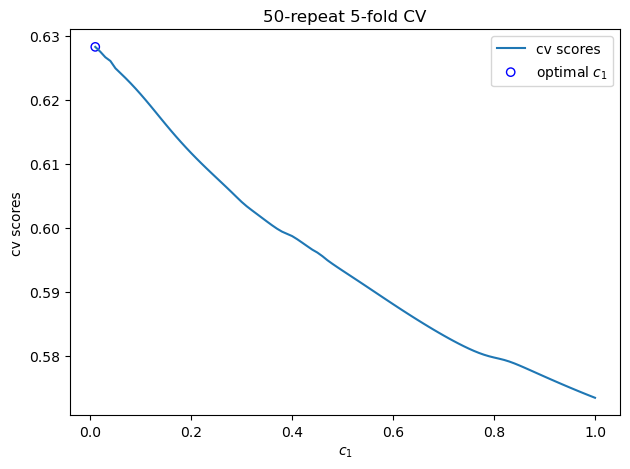

In [9]:
fig, ax = plt.subplots()

ax.plot(
    c1_arr, 
    cv_scores, 
    label='cv scores'
)
ax.scatter(
    c1_opt, cv_scores[c1_opt_ind], 
    fc='none', ec='blue', label='optimal $c_1$'
)

ax.set(
    xlabel='$c_1$', 
    ylabel='cv scores', 
    title='{}-repeat {}-fold CV'.format(n_repeats, n_splits)
)
ax.legend()

fig.tight_layout()

In [12]:
X_train = StandardScaler().fit_transform(X_train)
Y_train = StandardScaler().fit_transform(Y_train)

[cc, wx, wy] = solve_std_eig_for_rcc(X_train, Y_train, c1_opt, c2)

If we do a comparison for the first five canonical correlation down below, we can see that they are close:

In [19]:
print('CC original:')
print(np.array([
    0.999965422013286, 0.999922061899971, 
    0.999871922750539, 0.999713240154330, 
    0.999370754240536
]))
print('CC computed:')
print(cc[:5])

CC original:
[0.99996542 0.99992206 0.99987192 0.99971324 0.99937075]
CC computed:
[0.99996645 0.99992437 0.99987576 0.99972213 0.99938939]
